# Performing sentiment analysis on the yelp reviews dataset using a fine-tuned DistilBERT model.

This notebook is an implementation of a sentiment analysis performed on a cleaned version of the [Yelp dataset](https://huggingface.co/datasets/noahnsimbe/yelp-dataset). 
It contains model development, hyperparameter tuning, evaluation and analysis of performance. 

- [Information about the base model](https://huggingface.co/docs/transformers/model_doc/distilbert)
- [Information about ray use cases](https://docs.ray.io/en/latest/ray-overview/use-cases.html)
- [Ray tuning example](https://docs.ray.io/en/latest/train/examples/transformers/huggingface_text_classification.html)
- [Training](https://huggingface.co/docs/transformers/en/training)


## Set up a ray cluster

Change `--num-cpus` to match CPUs on each machine

### Start the Head node
```shell
ray start --head --port=7374 --num-cpus=24
```

### Start Worker Nodes
```shell
ray start --address=<head-node-address:port> --num-cpus=24
```

### View Dashboard
```shell
ray dashboard
```

## Installing required packages

In [ ]:
! export RAY_PICKLE_VERBOSE_DEBUG='2'
! export RAY_AIR_NEW_OUTPUT='1'
# ! export RAY_ADDRESS="http://127.0.0.1:8265"

In [ ]:
! pip install -U -q datasets "transformers[torch]" "ray[tune]" evaluate scikit-learn seaborn

## Importing required packages

In [1]:
%%time
from datasets import load_dataset, Dataset, concatenate_datasets
from transformers import (
    AutoTokenizer,
    DataCollatorWithPadding,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    pipeline,
    get_linear_schedule_with_warmup,
)
from torch.optim import AdamW
import numpy as np
from huggingface_hub import notebook_login
from ray import tune
import ray
import evaluate
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import os
from typing import Tuple, Dict

CPU times: user 4.89 s, sys: 4.62 s, total: 9.51 s
Wall time: 4.04 s


In [2]:
base_model_checkpoint = "distilbert-base-uncased"
model_checkpoint = "noahnsimbe/DistilBERT-yelp-sentiment-analysis"
batch_size = 8
dataset_checkpoint = "noahnsimbe/yelp-dataset"
data_fraction = 0.05
num_train_epochs = 10
RAY_ADDRESS = os.getenv("RAY_ADDRESS")

## Data Loading

In [3]:
%%time
data = load_dataset(dataset_checkpoint)

CPU times: user 183 ms, sys: 7.76 ms, total: 191 ms
Wall time: 5.89 s


## Data Preprocessing

### Using a fraction of the data
Due to resource limitations, we shall use 0.1 of the train, test and evaluation dataset.

In [4]:
def filter_data(dataset):
    negative_reviews = dataset.filter(lambda review: review['label'] == 0)
    neutral_reviews = dataset.filter(lambda review: review['label'] == 1)
    positive_reviews = dataset.filter(lambda review: review['label'] == 2)

    negative_reviews = negative_reviews.train_test_split(train_size=data_fraction)["train"]
    neutral_reviews = neutral_reviews.train_test_split(train_size=data_fraction)["train"]
    positive_reviews = positive_reviews.train_test_split(train_size=data_fraction)["train"]

    return concatenate_datasets([negative_reviews, neutral_reviews, positive_reviews]).shuffle(seed=42)

In [5]:
train_data = filter_data(data["train"])
test_data = filter_data(data["test"])
eval_data = filter_data(data["eval"])

### Creating tokenizer from the pre-trained DistilBERT model

In [6]:
tokenizer = AutoTokenizer.from_pretrained(base_model_checkpoint)

In [7]:
def tokenize_review(review: Dict) -> Dict:
    """
    Tokenizes the text in a given review text using the tokenizer with truncation.

    Args:
        record (dict): A dictionary containing the text to be tokenized under the key "text".

    Returns:
        dict: A dictionary containing the tokenized text.
    """
    return tokenizer(review["text"], truncation=True)

### Tokenize the text using the tokenizer with truncation

In [8]:
%%time
tokenized_train_data = train_data.map(tokenize_review, batched=True)
tokenized_test_data = test_data.map(tokenize_review, batched=True)
tokenized_eval_data = eval_data.map(tokenize_review, batched=True)

train_dataset = Dataset.from_list(tokenized_train_data)
test_dataset = Dataset.from_list(tokenized_test_data)
eval_dataset = Dataset.from_list(tokenized_eval_data)

Map:   0%|          | 0/6170 [00:00<?, ? examples/s]

Map:   0%|          | 0/770 [00:00<?, ? examples/s]

Map:   0%|          | 0/770 [00:00<?, ? examples/s]

CPU times: user 4.85 s, sys: 149 ms, total: 5 s
Wall time: 3.09 s


### Creating the DataCollatorWithPadding object

In [9]:
%%time

# Converts the training reviews to PyTorch tensors and concatenate them with the correct amount of padding to speed up training
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

CPU times: user 14 µs, sys: 6 µs, total: 20 µs
Wall time: 23.6 µs


## Model Development

### Load pre-trained model for sequence classification

In [10]:
%%time
model = AutoModelForSequenceClassification.from_pretrained(
    base_model_checkpoint, num_labels=3
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


CPU times: user 252 ms, sys: 155 ms, total: 407 ms
Wall time: 197 ms


### Define the metrics to evaluate the model

In [11]:
def compute_metrics(eval_pred: Tuple) -> Dict[str, float]:
    """
    Compute various evaluation metrics such as accuracy, F1 score, precision, and recall.

    Args:
        eval_pred (tuple): A tuple containing the model predictions (logits) and the ground truth labels.

    Returns:
        dict: A dictionary containing computed evaluation metrics (accuracy, F1 score, precision, and recall).
    """
        
    load_accuracy = evaluate.load("accuracy", trust_remote_code=True)
    load_f1 = evaluate.load("f1", trust_remote_code=True)
    load_precision = evaluate.load("precision", trust_remote_code=True)
    load_recall = evaluate.load("recall", trust_remote_code=True)
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    accuracy = load_accuracy.compute(predictions=predictions, references=labels)[
        "accuracy"
    ]
    f1 = load_f1.compute(predictions=predictions, references=labels, average="macro")[
        "f1"
    ]
    precision = load_precision.compute(
        predictions=predictions, references=labels, average="macro", zero_division=0
    )["precision"]
    recall = load_recall.compute(
        predictions=predictions, references=labels, average="macro"
    )["recall"]
    return {"accuracy": accuracy, "f1": f1, "precision": precision, "recall": recall}

### Define training arguments for the model training process

In [12]:
notebook_login()

In [13]:
training_args = TrainingArguments(
    output_dir=model_checkpoint,
    learning_rate=2e-5,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_train_epochs,
    weight_decay=0.01,
    load_best_model_at_end=True,
    push_to_hub=True,
    use_cpu=True,
)

### Define the optimizer and learning rate scheduler

In [14]:
optimizer = AdamW(model.parameters(), lr=5e-5)
lr_scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=len(train_dataset) * training_args.num_train_epochs,
)

### Define the Trainer for model training

In [15]:
model_trainer = Trainer(
    model,
    training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    data_collator=data_collator,
    optimizers=(optimizer, lr_scheduler),
)

/home/ayepwebsite/ad-dl/venv/lib/python3.8/site-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


### Train the model

In [16]:
%%time
model_trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.576400,0.466877,0.829870,0.606799,0.622887,0.623880
2,0.388000,0.581430,0.780519,0.649702,0.635591,0.681471
3,0.268900,0.712479,0.827273,0.716878,0.726131,0.726639
4,0.201900,0.805653,0.823377,0.684357,0.684228,0.684655
5,0.149800,0.961066,0.835065,0.689045,0.695172,0.683565
6,0.100900,1.067954,0.816883,0.692371,0.693020,0.698062
7,0.076200,1.214747,0.824675,0.664153,0.666533,0.662645
8,0.044100,1.393869,0.814286,0.701591,0.712524,0.714277
9,0.047100,1.290316,0.832468,0.710867,0.713646,0.711558
10,0.054000,1.102420,0.844156,0.708875,0.718047,0.703523


CPU times: user 17h 43min 11s, sys: 19min 5s, total: 18h 2min 17s
Wall time: 1h 33min 29s


TrainOutput(global_step=7720, training_loss=0.18452841210241763, metrics={'train_runtime': 5584.3678, 'train_samples_per_second': 11.049, 'train_steps_per_second': 1.382, 'total_flos': 2614266413188452.0, 'train_loss': 0.18452841210241763, 'epoch': 10.0})

In [20]:
model_trainer.evaluate(eval_dataset=eval_dataset)

{'eval_loss': 0.4802529215812683,
 'eval_accuracy': 0.8298701298701299,
 'eval_f1': 0.6262787850061224,
 'eval_precision': 0.6756062343232129,
 'eval_recall': 0.6341881589681134,
 'eval_runtime': 19.3931,
 'eval_samples_per_second': 39.705,
 'eval_steps_per_second': 5.002,
 'epoch': 10.0}

In [21]:
model_trainer.push_to_hub()

events.out.tfevents.1713288960.ad-dl:   0%|          | 0.00/512 [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/noahnsimbe/DistilBERT-yelp-sentiment-analysis/commit/df38945604dea416ff381274186560a34426e404', commit_message='End of training', commit_description='', oid='df38945604dea416ff381274186560a34426e404', pr_url=None, pr_revision=None, pr_num=None)

### Observation

The model's performance improves over the epochs in terms of loss reduction and validation metrics such as accuracy, F1 score, precision, and recall. However, there are fluctuations in the metrics across epochs, indicating possible overfitting or instability in training.

## Model Evaluation

### Evalute the model

In [28]:
%%time
model_trainer.evaluate(eval_dataset=eval_dataset)

CPU times: user 3min 25s, sys: 1.88 s, total: 3min 27s
Wall time: 19.3 s


{'eval_loss': 0.4802529215812683,
 'eval_accuracy': 0.8298701298701299,
 'eval_f1': 0.6262787850061224,
 'eval_precision': 0.6756062343232129,
 'eval_recall': 0.6341881589681134,
 'eval_runtime': 19.2559,
 'eval_samples_per_second': 39.988,
 'eval_steps_per_second': 5.037,
 'epoch': 10.0}

In [29]:
model_pipeline = pipeline("text-classification", model=model_trainer.model, tokenizer=tokenizer)

In [30]:
%%time
predictions = model_pipeline(eval_dataset["text"])
y_test = eval_dataset["label"]

CPU times: user 4min 25s, sys: 102 ms, total: 4min 25s
Wall time: 22.1 s


In [31]:
label_mapping = {
    'LABEL_0': 0,
    'LABEL_1': 1,
    'LABEL_2': 2
}
class_labels = ["Negative", "Neutral", "Positive"]

### Generate predictions and evaluation metrics.

In [32]:
y_pred = list(map(lambda x: label_mapping[x['label']], predictions))
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred, target_names=class_labels)

### Classification report

In [33]:
print(f"Classification Report:\n{classification_rep}")

Classification Report:
              precision    recall  f1-score   support

    Negative       0.76      0.85      0.80       183
     Neutral       0.39      0.11      0.17        85
    Positive       0.87      0.94      0.91       502

    accuracy                           0.83       770
   macro avg       0.68      0.63      0.63       770
weighted avg       0.79      0.83      0.80       770



### Confusion Matrix

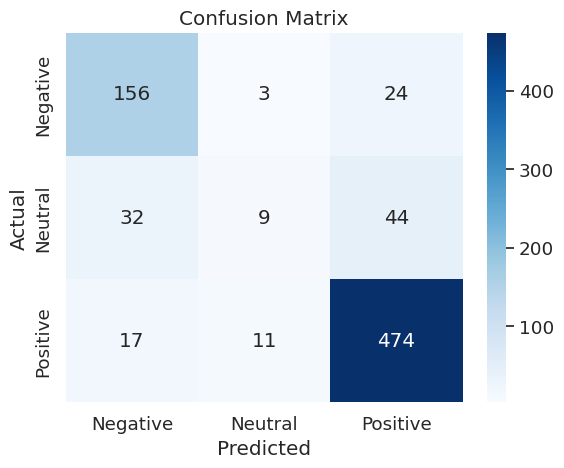

In [34]:
sns.set(font_scale=1.2)
sns.heatmap(
    conf_matrix,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_labels,
    yticklabels=class_labels,
)

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

### Observation

The model's performance improves over the epochs in terms of loss reduction and validation metrics such as accuracy, F1 score, precision, and recall. However, there are fluctuations in the metrics across epochs, indicating possible overfitting or instability in training. 

### Updating Hub

In [35]:
model_trainer.push_to_hub()

events.out.tfevents.1713288960.ad-dl:   0%|          | 0.00/984 [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/noahnsimbe/DistilBERT-yelp-sentiment-analysis/commit/2818af7df821d8176a4c0d2b00c4508ade741ecb', commit_message='End of training', commit_description='', oid='2818af7df821d8176a4c0d2b00c4508ade741ecb', pr_url=None, pr_revision=None, pr_num=None)

## Hyperparameter Tuning

In [36]:
def model_init():
    return AutoModelForSequenceClassification.from_pretrained(
        base_model_checkpoint, num_labels=3, return_dict=True
    )

In [37]:
hp_trainer = Trainer(
    args=training_args,
    tokenizer=tokenizer,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    model_init=model_init,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

/home/ayepwebsite/ad-dl/venv/lib/python3.8/site-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [38]:
def ray_hp_space(_):
    return {
        "learning_rate": tune.loguniform(1e-6, 1e-4),
        "per_device_train_batch_size": tune.choice([2, 4, 8]),
        "per_device_eval_batch_size": tune.choice([4, 8]),
        "weight_decay": tune.choice([0.001, 0.01, 0.1]),
        "num_train_epochs": tune.choice([2, 4, 6, 10]),
    }

In [39]:
setattr(hp_trainer.args, "push_to_hub", False)

In [ ]:
%%time
ray.init()
# ray.init(f"ray://{RAY_ADDRESS}")
results = hp_trainer.hyperparameter_search(
    direction="maximize",
    backend="ray",
    hp_space=ray_hp_space,
    resources_per_trial={"cpu": 24},
    n_trials=4,
)
ray.shutdown()

In [ ]:
results

## Training using best hyperparameters

In [ ]:
for n, v in best_trial.hyperparameters.items():
    setattr(model_trainer.args, n, v)

### Loading 50% of the entire dataset

In [ ]:
%%time
data_fraction = 0.5

train_data = filter_data(data["train"])
test_data = filter_data(data["test"])
eval_data = filter_data(data["eval"])

tokenized_train_data = train_data.map(preprocess_function, batched=True)
tokenized_test_data = test_data.map(preprocess_function, batched=True)
tokenized_eval_data = eval_data.map(preprocess_function, batched=True)

train_dataset = Dataset.from_list(tokenized_train_data)
test_dataset = Dataset.from_list(tokenized_test_data)
eval_dataset = Dataset.from_list(tokenized_eval_data)

In [ ]:
setattr(model_trainer.args, "train_dataset", train_dataset)
setattr(model_trainer.args, "test_dataset", test_dataset)

### Connecting to the Hub

In [ ]:
notebook_login()

In [ ]:
setattr(model_trainer.args, "push_to_hub", True)

### Training the model

In [ ]:
%%time
model_trainer.train()

### Evaluating the model

In [ ]:
%%time
model_trainer.evaluate(eval_dataset=eval_dataset)

### Uploading the model to Hub

In [ ]:
%%time
model_trainer.push_to_hub()

## Analysing Model Performance

In [ ]:
model = pipeline("text-classification", model=model_checkpoint)
max_length = 200

### Analysis of long reviews

In [ ]:
long_text_dataset = eval_dataset.filter(lambda review: len(review['text']) > max_length)
long_reviews = [review for review in eval_dataset["text"] if len(review) > max_length]

In [ ]:
long_reviews_predictions = model.predict(long_reviews)

In [ ]:

short_text_dataset = eval_dataset.filter(lambda review: len(review['text']) <= max_length)

In [ ]:

short_reviews = [review for review in eval_dataset["text"] if len(review) <= max_length]

## Challenges encountered
- Training and evaluting the Distilbert model on the Yelp dataset for sentiment analysis required alot of computational resources. this greatly affected the model development. 